In [1]:
# # Download the dataset
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
# !unzip AirQualityUCI.zip


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras


In [18]:
# Load the dataset
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])

# Select only relevant columns and drop missing data
df = df[['Date_Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)']]
df = df.dropna()

<ipython-input-18-041602cc6646>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])
<ipython-input-18-041602cc6646>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])


In [19]:
# Check the statistics of the CO(GT) values
print(df['CO(GT)'].describe())

# Check for missing or negative values
missing_values = df['CO(GT)'].isnull().sum()
negative_values = (df['CO(GT)'] < 0).sum()
print(f"Missing Values: {missing_values}, Negative Values: {negative_values}")


count    9357.000000
mean      -34.207524
std        77.657170
min      -200.000000
25%         0.600000
50%         1.500000
75%         2.600000
max        11.900000
Name: CO(GT), dtype: float64
Missing Values: 0, Negative Values: 1683


In [20]:
# Replace negative values with NaN
df['CO(GT)'] = df['CO(GT)'].apply(lambda x: np.nan if x < 0 else x)

# You can then apply interpolation to fill missing values
df['CO(GT)'] = df['CO(GT)'].interpolate()

# Normalize the data to [0, 1] range for LSTM
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)']])

# Convert back to a DataFrame for convenience
df_scaled = pd.DataFrame(df_scaled, columns=['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)'])


In [6]:
# Define a function to create sequences of time steps
def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])  # Predicting 'CO(GT)'
    return np.array(X), np.array(y)

# Create sequences
time_steps = 5  # Looking back 5 time steps
X, y = create_sequences(df_scaled.values, time_steps)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer predicting 'CO(GT)'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


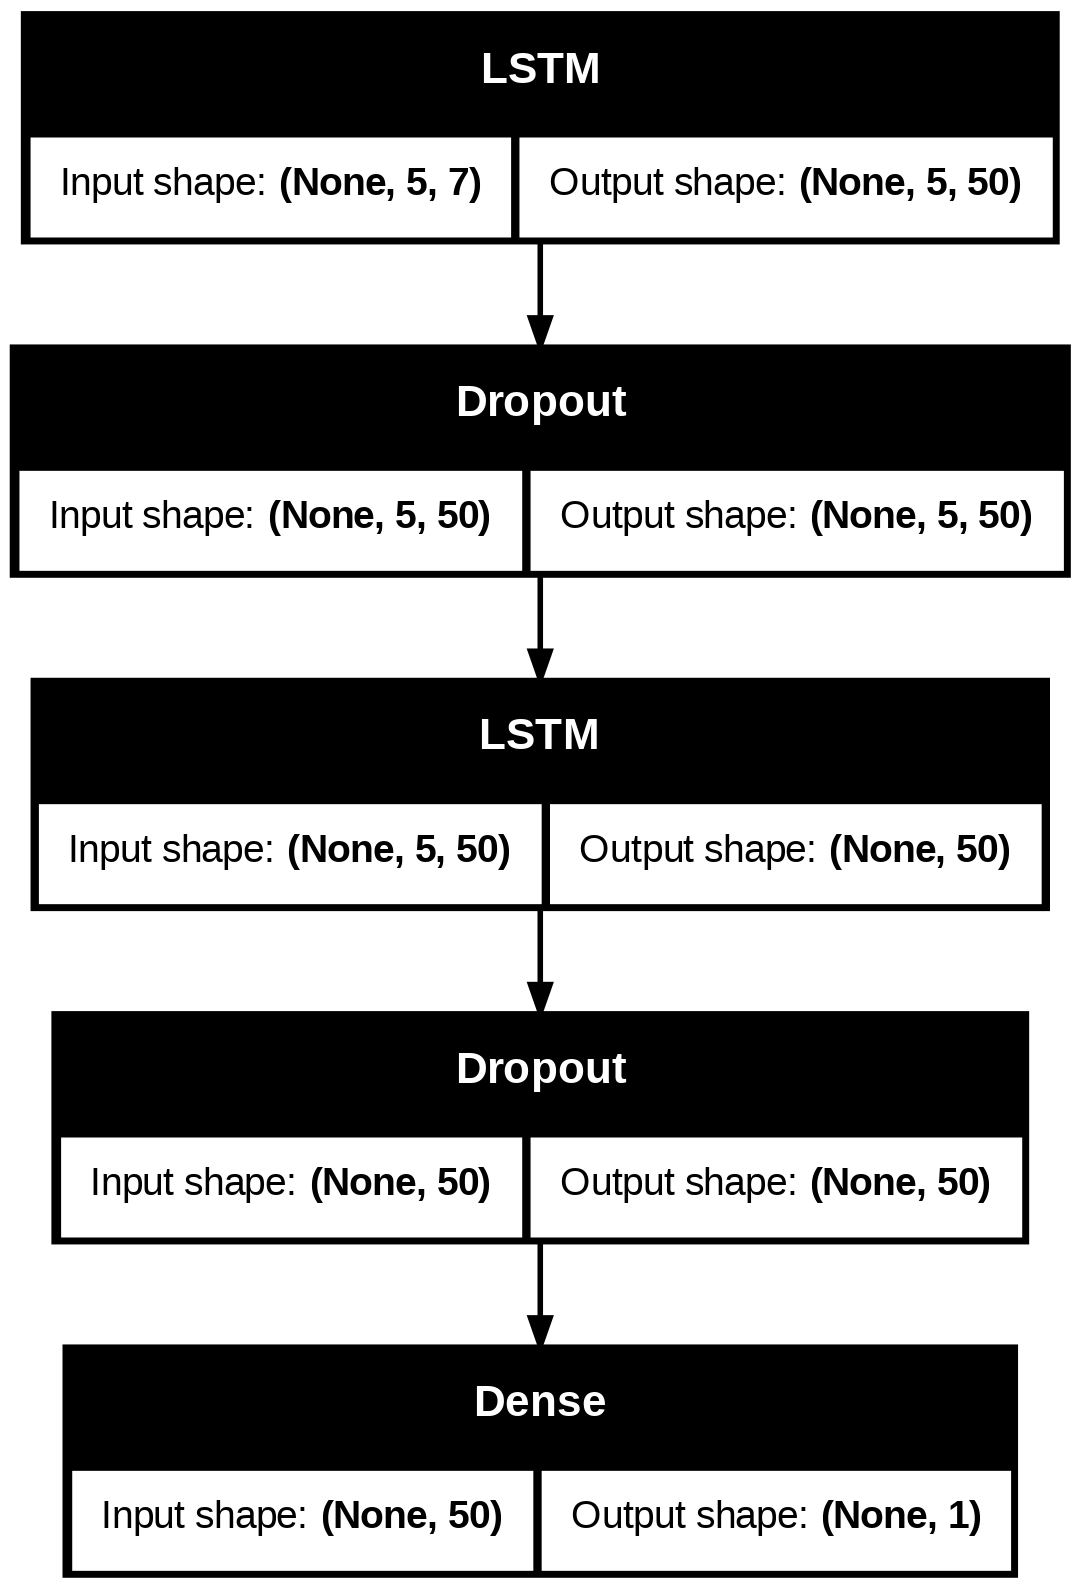

In [8]:
keras.utils.plot_model(model,show_shapes=True)

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0121 - val_loss: 0.0110
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8

In [10]:
# Make predictions
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Root Mean Squared Error (RMSE): 0.05614200725706628


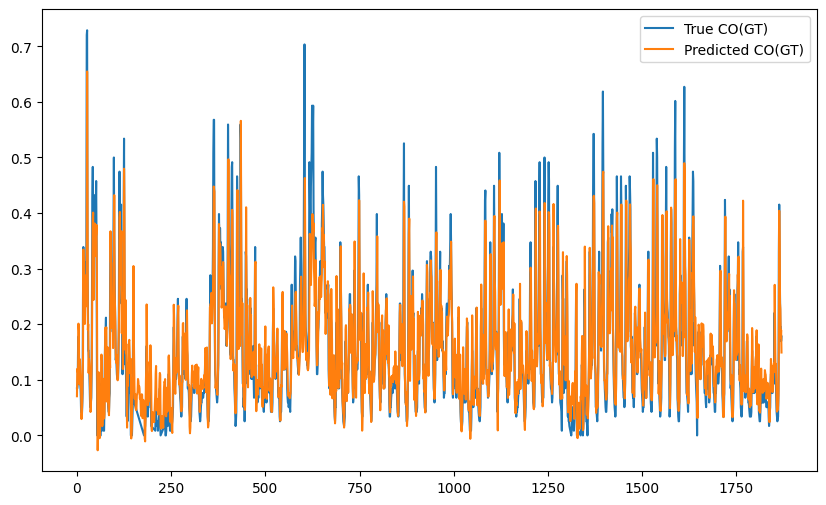

In [11]:
# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True CO(GT)')
plt.plot(y_pred, label='Predicted CO(GT)')
plt.legend()
plt.show()
